## Data Generators & Class Imbalance Solutions
## Fixes for Class Imbalance
### Solutions Implemented:
1. **Focal Loss** - Better than categorical crossentropy for imbalanced data
2. **Aggressive Class Weights** - Squared scaling for extreme cases
3. **Heavy Augmentation** - More variations for minority classes
4. **Smaller Batch Size** - 16 instead of 32 ensures minority classes appear
5. **Balanced Accuracy** - Don't let majority class dominate metrics

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")

TensorFlow version: 2.20.0
Libraries imported successfully!


In [2]:
BASE_DIR = r'D:\Projects\MulticlassFishImageClassification\data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 16  # Smaller batch for minority class representation
EPOCHS = 50
NUM_CLASSES = 11

print("Configuration loaded")

Configuration loaded


## 1. Custom Focal Loss Implementation

**Why Focal Loss?**
- Categorical Crossentropy treats all classes equally
- Focal Loss focuses more on hard-to-classify examples for minority classes
- Reduces the impact of easy examples of majority class
- Focal Loss for handling class imbalance
- Args:
        - gamma: Focusing parameter (higher = more focus on hard examples)
        - alpha: Balancing parameter
    
- Returns:  Loss function
 

In [3]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate focal loss
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    return focal_loss_fixed

print("Focal Loss function defined")
print("This loss will focus more on minority classes!")

Focal Loss function defined
This loss will focus more on minority classes!


## 2. Data Generators with Heavy Augmentation
### Create data generators with HEAVY augmentation for training and This helps minority classes get more variations
 

In [4]:
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.6, 1.4]
    )
    
    # Only rescaling for validation/test
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    # Validation generator
    valid_generator = valid_test_datagen.flow_from_directory(
        VALID_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Test generator
    test_generator = valid_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, valid_generator, test_generator

print("Creating data generators...")
train_gen, valid_gen, test_gen = create_data_generators()

print("\n" + "="*80)
print("DATA GENERATORS CREATED")
print("="*80)
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")
print(f"Test samples: {test_gen.samples}")
print(f"Batch size: {BATCH_SIZE} (Small batch = better minority representation)")
print(f"Steps per epoch: {train_gen.samples // BATCH_SIZE}")
print("\nClass indices:")
for class_name, idx in sorted(train_gen.class_indices.items(), key=lambda x: x[1]):
    print(f"  {idx}: {class_name}")
print("="*80)

Creating data generators...
Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.

DATA GENERATORS CREATED
Training samples: 6225
Validation samples: 1092
Test samples: 3187
Batch size: 16 (Small batch = better minority representation)
Steps per epoch: 389

Class indices:
  0: animal fish
  1: animal fish bass
  2: fish sea_food black_sea_sprat
  3: fish sea_food gilt_head_bream
  4: fish sea_food hourse_mackerel
  5: fish sea_food red_mullet
  6: fish sea_food red_sea_bream
  7: fish sea_food sea_bass
  8: fish sea_food shrimp
  9: fish sea_food striped_red_mullet
  10: fish sea_food trout


Visualizing augmented images...


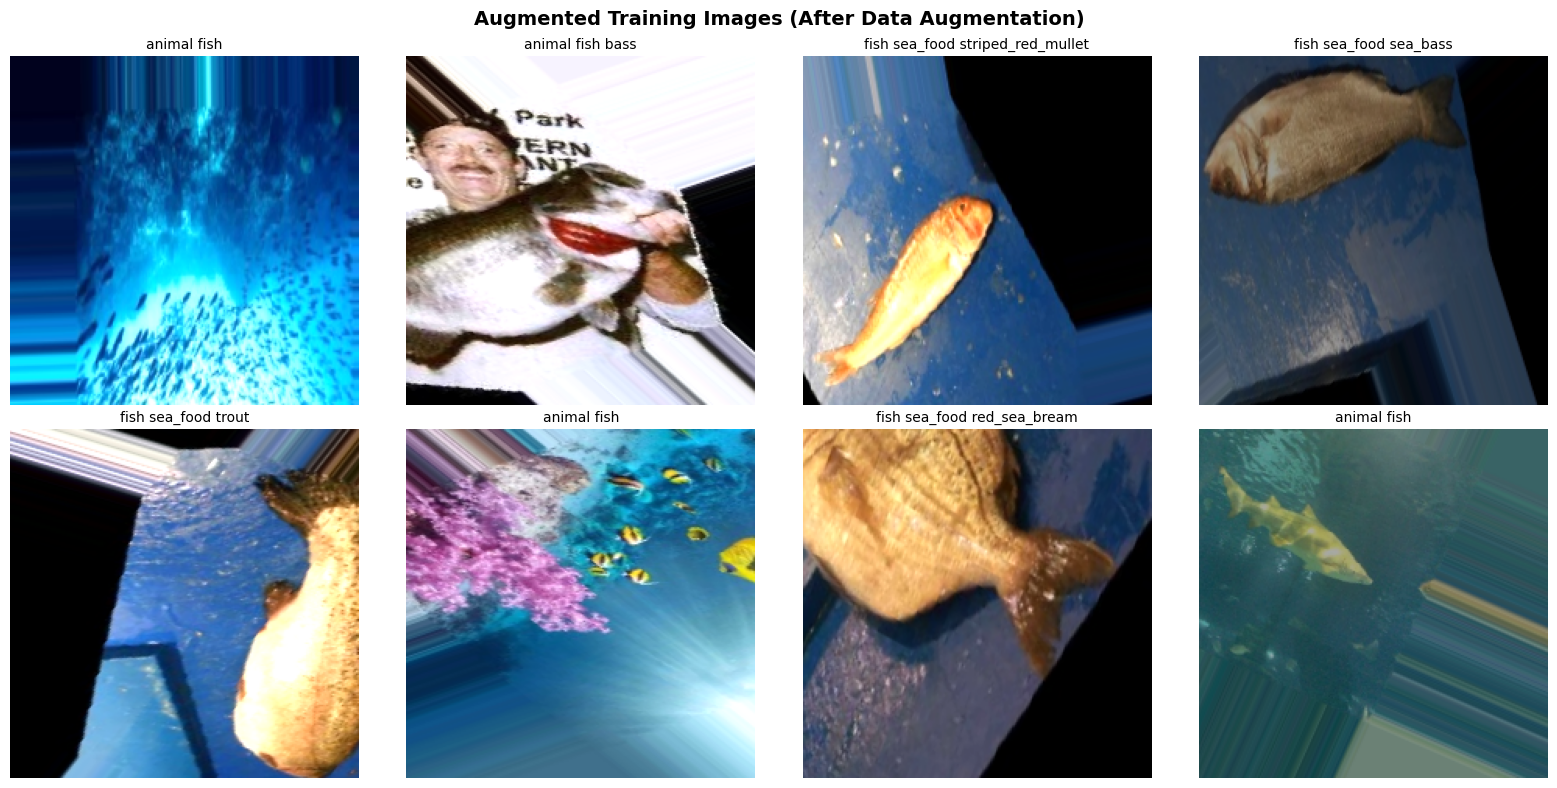

Augmented samples saved to results/plots/augmented_samples.png


In [5]:
"""Visualize augmented training images"""
def visualize_augmentation(generator, num_images=8): 
    images, labels = next(generator)    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[class_idx]
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Augmented Training Images (After Data Augmentation)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/plots/augmented_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing augmented images...")
visualize_augmentation(train_gen)
print("Augmented samples saved to results/plots/augmented_samples.png")

## Class Weights
**Key Insight**: Standard class weights may not be enough for 36:1 imbalance.
We'll use **squared scaling** to make the effect

In [6]:
""" Compute aggressive class weights using squared scaling.    
    Args:
        generator: Keras ImageDataGenerator
        scaling_factor: Exponent for weight scaling (higher = more aggressive)
    Returns:
        Dictionary of class weights
    """
def compute_aggressive_class_weights(generator, scaling_factor=2.0):
   
    class_labels = generator.classes
    
    # Compute standard balanced weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(class_labels),
        y=class_labels
    )
    
    # Apply aggressive scaling (square the weights)
    class_weights_aggressive = np.power(class_weights, scaling_factor)
    
    # Normalize to prevent exploding weights
    class_weights_aggressive = class_weights_aggressive / class_weights_aggressive.min()
    
    class_weight_dict = dict(enumerate(class_weights_aggressive))
    
    return class_weight_dict, class_labels, class_weights

print("Computing aggressive class weights...")
class_weight_dict, train_labels, standard_weights = compute_aggressive_class_weights(
    train_gen, scaling_factor=1.5  # 1.5 for aggressive, 2.0 for very aggressive
)

# Create comparison DataFrame
comparison_data = []
for class_idx in range(NUM_CLASSES):
    class_name = list(train_gen.class_indices.keys())[class_idx]
    count = np.sum(train_labels == class_idx)
    std_weight = standard_weights[class_idx]
    agg_weight = class_weight_dict[class_idx]
    
    comparison_data.append({
        'Class': class_name,
        'Count': count,
        'Standard_Weight': std_weight,
        'Aggressive_Weight': agg_weight,
        'Increase': f"{(agg_weight/std_weight - 1)*100:.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Count', ascending=True)

print("\n" + "="*100)
print("CLASS WEIGHTS COMPARISON: Standard vs Aggressive")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)
print("\n Notice how minority classes get MUCH higher weights!")
print("This forces the model to pay more attention to them during training.")
print("="*100)

Computing aggressive class weights...

CLASS WEIGHTS COMPARISON: Standard vs Aggressive
                           Class  Count  Standard_Weight  Aggressive_Weight Increase
                animal fish bass     30        18.863636         220.817734  1070.6%
          fish sea_food sea_bass    538         1.051876           2.907652   176.4%
fish sea_food striped_red_mullet    547         1.034569           2.836187   174.1%
   fish sea_food gilt_head_bream    566         0.999839           2.694581   169.5%
   fish sea_food black_sea_sprat    569         0.994568           2.673298   168.8%
     fish sea_food red_sea_bream    571         0.991084           2.659265   168.3%
   fish sea_food hourse_mackerel    573         0.987625           2.645355   167.9%
            fish sea_food shrimp    576         0.982481           2.624715   167.2%
        fish sea_food red_mullet    579         0.977390           2.604342   166.5%
             fish sea_food trout    580         0.975705      

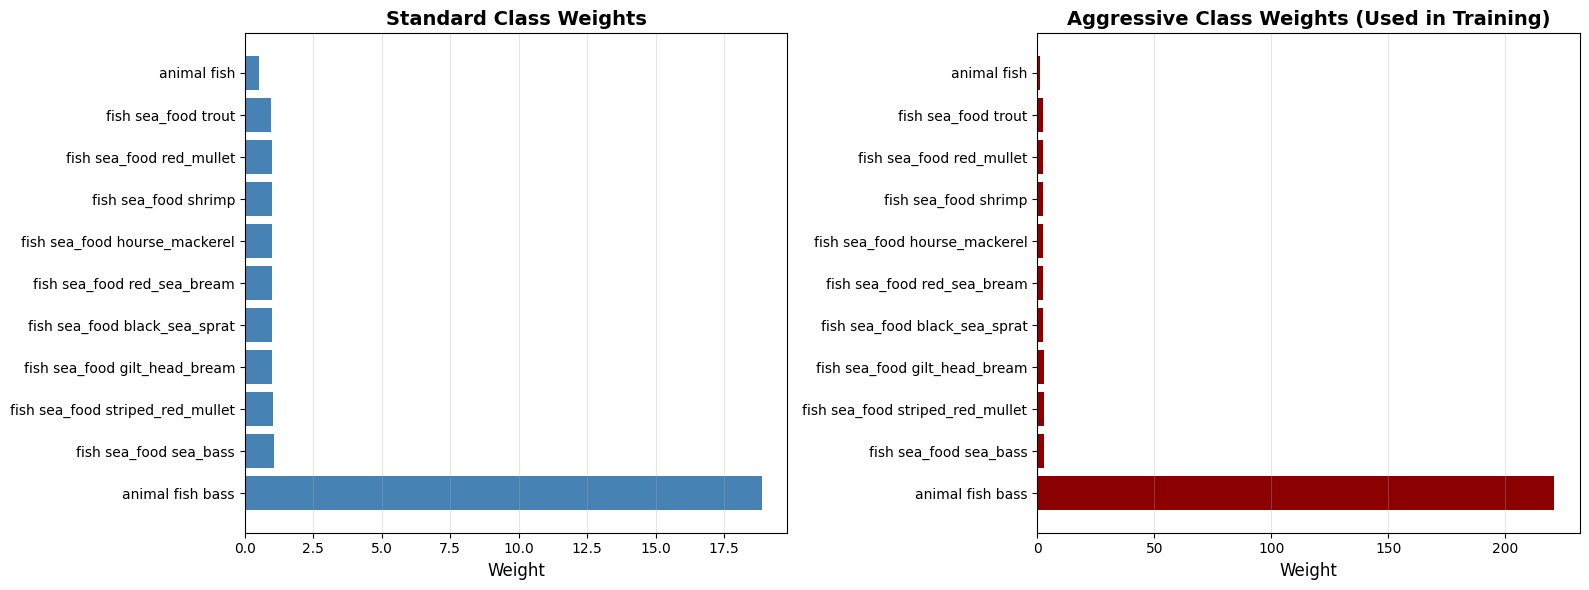

✓ Class weights comparison saved
Class weights saved to results/metrics/class_weights_comparison.csv


In [7]:
# Visualize class weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Standard weights
ax1.barh(comparison_df['Class'], comparison_df['Standard_Weight'], color='steelblue')
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Standard Class Weights', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Aggressive weights
ax2.barh(comparison_df['Class'], comparison_df['Aggressive_Weight'], color='darkred')
ax2.set_xlabel('Weight', fontsize=12)
ax2.set_title('Aggressive Class Weights (Used in Training)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/class_weights_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class weights comparison saved")

# Save weights to file
comparison_df.to_csv('results/metrics/class_weights_comparison.csv', index=False)
print("Class weights saved to results/metrics/class_weights_comparison.csv")

## 4. Callbacks Configuration

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(model_name, patience=15):
    callbacks = [
        # Early Stopping - stop if no improvement
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=f'models/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    return callbacks

print("Callbacks configured:")
print("  • Early Stopping (patience=15)")

Callbacks configured:
  • Early Stopping (patience=15)


## 5. Helper Functions for Training

In [9]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save history to CSV
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'results/metrics/{model_name}_training_history.csv', index=False)
    
    return history_df

print("Helper functions defined")

Helper functions defined


## Summary
1. **Focal Loss** - Better loss function for imbalanced data
2. **Heavy Data Augmentation** - More variations for all classes
3. **Aggressive Class Weights** - Squared scaling for minority classes
4. **Small Batch Size** - 16 instead of 32 for better representation
5. **Proper Callbacks** - Early stopping and LR reduction
